In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow.keras.metrics import MeanIoU, IoU
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import seaborn as sns
import pandas as pd

# Introduction
Semantic segmentation is the classification of an image on a pixel-by-pixel basis. An semantic segmentation pipeline takes as inputs an image and creates a mask. The mask is the same dimension as the image, but instead of each pixel representing a color value, each pixel represents a class.

Historically there have been several ways to perform semantic segmentation tasks using machine learning; however, many semantic segmentation tasks are video-based, and many historical semantic segmentation methods are slow. A desirable quality in a semantic segmentation pipline is thus to only use 1 model to perform the task efficiently.

One model with this quality is U-Net. U-Net uses an encoder-decoder method to first downsample an image using convolutional layers, then upsample the image using transpose convolutions. Outputs from the encoder layers are saved and concatenated to outputs from the encoder layer. U-Net thus takes in images in the form (height, width, num_color_channels) and outputs masks in the form (height, width, num_classes), that is, it performs the full semantic segmentation task.

Here, a U-Net model is built from scratch and trained to create semantic segmentation masks that locate animals in picture.

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf images.tar.gz

!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  755M    0  8192    0     0  10730      0 20:30:04 --:--:-- 20:30:04 10736
  0  755M    0 2635k    0     0  1566k      0  0:08:13  0:00:01  0:08:12 1566k
  1  755M    1  9.9M    0     0  3786k      0  0:03:24  0:00:02  0:03:22 3786k
  2  755M    2 18.2M    0     0  5082k      0  0:02:32  0:00:03  0:02:29 5083k
  3  755M    3 27.0M    0     0  5910k      0  0:02:10  0:00:04  0:02:06 5911k
  4  755M    4 36.1M    0     0  6519k      0  0:01:58  0:00:05  0:01:53 7530k
  6  755M    6 45.5M    0     0  6983k      0  0:01:50  0:00:06  0:01:44 8806k
  7  755M    7 54.9M    0     0  7330k      0  0:01:45  0:00:07  0:01:38 9232k
  8  755M    8 64.7M    0     0  7642k      0  0:01:41  0:00:08  0:01:33 9530k
  9  755M    9 74.3M    0     0  7871k      0  0:01

In [2]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'
img_size = (160, 160)
num_classes = 3



input_img_paths = sorted([
    os.path.join(input_dir, fname) for fname in os.listdir(input_dir)if fname.endswith(".jpg")
])
target_img_paths = sorted([
    os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')
])

print('number of samples: ', len(input_img_paths))


number of samples:  7390


Below is a sample image.


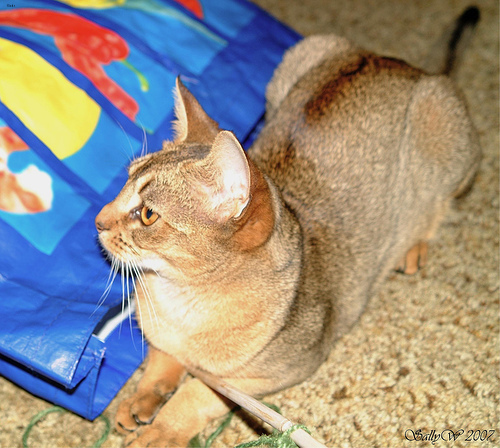

And below is its correesponding mask.


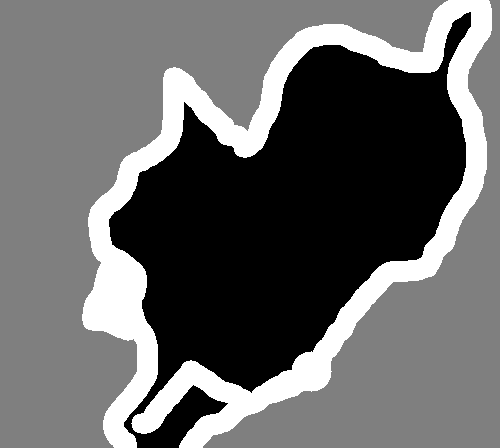

In [3]:
print('Below is a sample image.')
display(Image(filename=input_img_paths[9]))

mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
print('And below is its correesponding mask.')
display(mask)

# Loading and Preprocessing Images and Masks

In [4]:
def load_images_masks(img_size, input_img_paths, target_img_paths):
    '''
    Loads images and masks.
    Parameters:
        img_size: the width and height each image should be after proccessing, shape (width, height)
        input_img_paths: location of images
        target_img_path: location of the masks
    Returns: x, y, the images and masks respectively
    '''
    x = []
    y = []
    # Load images
    print("Loading images.")
    for path in input_img_paths:
        # Normalize the images
        x.append(np.array(load_img(path, target_size=img_size))/255)
    # Load masks
    print('Loading masks')
    for path in target_img_paths:
        mask = np.array(load_img(path, target_size=img_size, color_mode='grayscale'))
        mask = np.expand_dims(mask, 2)
        mask -= 1
        y.append(mask)
    return np.array(x), np.array(y)

x, y = load_images_masks(img_size, input_img_paths, target_img_paths)  

Loading images.
Loading masks


The data is then split into train, test and validation sets.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

In [6]:
val_size = int(x_train.shape[0]*0.2)
x_val = x_train[:val_size]
y_val = y_train[:len(x_val)]

x_train = x_train[val_size:]
y_train = y_train[val_size:]

# Checking for "Empty" Masks
There may be some masks that only have less than 3 classes, while each mask should have a class for the background, the outline of the animal and the body of the animal. These are removed from the training set.

In [7]:
empty_masks = []
for mask in y_train:
    if np.unique(mask).shape[0] < 1:
        empty_masks.append(mask)
print(f'There were {len(empty_masks)} incorrectly formatted masks.')

x_train_clean = []
y_train_clean = []
if len(empty_masks) > 0:
    for i, mask in enumerate(y_train):
        if np.unique(mask).shape[0] > 1:
            x_train_clean.append(x_train[i])
            y_train_clean.append(mask)

There were 0 incorrectly formatted masks.


# Build model
## Model Architecture
The model architecture is based on the original [U-Net paper](https://arxiv.org/pdf/1505.04597.pdf). U-Net is aa model designed to classify images on a pixel-by-pixel basis in a fully convolutional manner. The model contains of down sampling and upsampling steps, connected to each other through skip connections. The result is a symmetrical U shape. While the parameters are not identical, the image below shows the general shape of the model.
<br>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="600" height = 500/><br>
A feature that distinguishes U-Net from a simple autoencoder is the use of skip connections. The skip connections take tensors after downsampling convolutions and concatenate them with tensors calculated during the upsampling, represented by the horizontal arrows in the middle of the U in the image above. This allows informattion used in the downsampling layers to be used during upsampling.

Note the model below deviates slightly from the original U-Net model. Batch normalization layers are added to help with training, and dropout layers are added to mitigate against overfitting.

## Intersection Over Union
The model's training progress is evaluated by using a mean intersection over union (IoU) metric. For any pair of segmentation target and prediction, for each class, the intersection over union is the intersection of the masks divided by its union. The intersection and union are the shared and total area covered by the masks, respectively, but using set operations rather than just comparing areas makes sure the metric is calculated in a space dependent way. The IoU ranges from 0 to 1. When the IoU is 0, then the intersection is zero, i.e. the predicted and target masks do not overlap at all. When the IoU is 1, then the predicted and target masks overlap perfectly. The mean IoU is the IoU averaged over each class.

In [8]:
def get_model(img_size, dropout_rate, num_classes=3, base_num_filters=64):
    '''
    Creates a modified U-Net model with dropout and batchnorm layers
    Parameters:
        img_size: the input image and output resolution, excluding color channels
        dropout_rate: the number of connections each dropout layer should ignore
        num_classes: the number of classes to be detected
        base_num_filters: the number of filters the first convolutional block uses
    Outputs: The U-Net model
    '''
    inputs = keras.Input(shape=img_size + (3,))
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(1, kernel_size=(3), activation='relu', padding='same')(inputs) 
    x = layers.Conv2D(base_num_filters, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(base_num_filters, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    
    # Second convolutional block
    x = layers.Conv2D(base_num_filters*2, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(base_num_filters*2, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    
    # Third convolutional block
    x = layers.Conv2D(base_num_filters*4, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(base_num_filters*4, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(base_num_filters*8, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(base_num_filters*8, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(base_num_filters*16, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(base_num_filters*16, kernel_size =(3), activation='relu', padding='same')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(base_num_filters*8, kernel_size=(2), strides=(2))(x)
    center_shape = (x.shape[1], x.shape[2])
    skip_con_4 = layers.CenterCrop(center_shape[0], center_shape[1])(skip_con_4)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) #want to add one layer "behind" the other
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(base_num_filters*8, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(base_num_filters*8, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
  
    # Second upconv layer
    x = layers.Conv2DTranspose(base_num_filters*4, kernel_size=(2), strides=(2))(x)
    center_shape = (x.shape[1], x.shape[2])
    skip_con_3 = layers.CenterCrop(center_shape[0], center_shape[1])(skip_con_3)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(base_num_filters*4, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(base_num_filters*4, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(base_num_filters*2, kernel_size=(2), strides=(2))(x)
    center_shape = (x.shape[1], x.shape[2])
    skip_con_2 = layers.CenterCrop(center_shape[0], center_shape[1])(skip_con_2)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(base_num_filters*2, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(base_num_filters*2, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(base_num_filters*4, kernel_size=(2), strides=(2))(x)
    center_shape = (x.shape[1], x.shape[2])
    skip_con_1 = layers.CenterCrop(center_shape[0], center_shape[1])(skip_con_1)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(base_num_filters*4, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(base_num_filters*4, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2D(num_classes, kernel_size=(1), activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model
    
keras.backend.clear_session()

# Build model
model = get_model(img_size,  dropout_rate=.25, num_classes=num_classes, base_num_filters=64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 1)  28          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 64  640         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

In [9]:
mean_iou = MeanIoU(num_classes=num_classes)

def IoU_metric(y_true, y_pred):
    '''
    Calculates the mean IOU across classes.
    Parameters:
        y_true: ground truth masks, shape (width, height, 1)
        y_pred: model outputs, shape (width, height, 3)

    '''
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.expand_dims(y_pred, axis=-1)
    mean_iou.update_state(y_true, y_pred)
    return mean_iou.result()

lr_plateau = ReduceLROnPlateau(
    monitor='val_IoU_metric',
    factor=0.1,
    patience=5,
    mode='max',
    verbose=1
)

es = EarlyStopping(
    monitor='val_IoU_metric',
    patience=10,
    mode='max',
    verbose=1,
    min_delta=0.0001,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint("oxford_segmentation.h5", save_best_only=False, )

model.compile(optimizer=Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=[IoU_metric, 'accuracy'])


epochs = 100
history = model.fit(x_train, y_train, epochs=epochs, validation_data=[x_val, y_val],  callbacks=[checkpoint, lr_plateau, es], batch_size=8)

Epoch 1/100
592/592 [==============================] - 274s 442ms/step - loss: 0.7873 - IoU_metric: 0.3467 - accuracy: 0.6822 - val_loss: 0.8311 - val_IoU_metric: 0.3597 - val_accuracy: 0.6681 - lr: 0.0010
Epoch 2/100
592/592 [==============================] - 264s 446ms/step - loss: 0.7522 - IoU_metric: 0.3627 - accuracy: 0.6969 - val_loss: 0.8688 - val_IoU_metric: 0.3693 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 3/100
592/592 [==============================] - 143s 241ms/step - loss: 0.5802 - IoU_metric: 0.3863 - accuracy: 0.7675 - val_loss: 0.5156 - val_IoU_metric: 0.4112 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 4/100
592/592 [==============================] - 127s 215ms/step - loss: 0.4533 - IoU_metric: 0.4349 - accuracy: 0.8227 - val_loss: 0.4553 - val_IoU_metric: 0.4565 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 5/100
592/592 [==============================] - 127s 215ms/step - loss: 0.4071 - IoU_metric: 0.4747 - accuracy: 0.8421 - val_loss: 0.3698 - val_IoU_metric: 0.4908 - val_

## Training Visualizations

In [10]:
history.history.keys()
history_df = pd.DataFrame.from_dict(history.history)
epochs = range(1, len(history.history['loss']) +1)

Text(0.5, 0.98, 'Comparing Traing and Validation Performance')

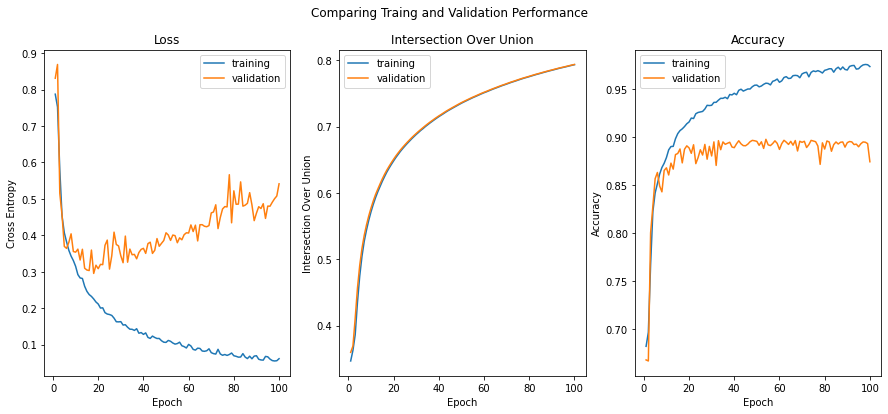

In [11]:
# Comparing Training and Validation Values
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Loss plot
sns.lineplot(data=history_df, x=epochs, y='loss', ax=axes[0])
sns.lineplot(data=history_df, x=epochs, y='val_loss', ax=axes[0])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross Entropy')
axes[0].set_title('Loss')
axes[0].legend(labels=['training', 'validation'])



# IoU plot
sns.lineplot(data=history_df, x=epochs, y='IoU_metric', ax=axes[1])
sns.lineplot(data=history_df, x=epochs, y='val_IoU_metric', ax=axes[1])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Intersection Over Union')
axes[1].set_title('Intersection Over Union')
axes[1].legend(labels=['training', 'validation'])


# Accuracy Plot
sns.lineplot(data=history_df, x=epochs, y='accuracy', ax=axes[2])
sns.lineplot(data=history_df, x=epochs, y='val_accuracy', ax=axes[2])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Accuracy')
axes[2].legend(labels=['training', 'validation'])

plt.suptitle('Comparing Traing and Validation Performance')


The above plots for the loss and accuracy are fairly standard in that they show performance improving until some generalization gap increases between the training and validation quantities. This typically signifies overfitting and decreasing performance on data from outside of the testing set. Here, however, the intersection over union for the validation set continues to increase as the model trains. Given that the generalization gap does not seem to affect the most relevant metric, the model with the highest intersection over union on the validation set is chosen for further analysis.

Text(0.5, 0.98, 'Comparing Training and Validation Performance')

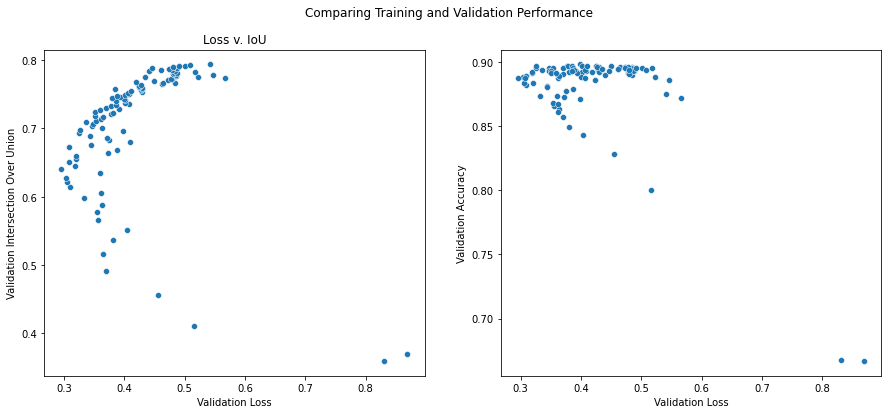

In [12]:
# Plotting Validation Metrics as Functions of Validation Loss
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Loss plot
sns.scatterplot(data=history_df, x='val_loss', y='val_IoU_metric', ax=axes[0])
axes[0].set_xlabel('Validation Loss')
axes[0].set_ylabel('Validation Intersection Over Union')
axes[0].set_title('Loss v. IoU')



# IoU plot
sns.scatterplot(data=history_df, x='val_loss', y='val_accuracy', ax=axes[1])
axes[1].set_xlabel('Validation Loss')
axes[1].set_ylabel('Validation Accuracy')


plt.suptitle('Comparing Training and Validation Performance')

The plot above show the validation intersection over union and the validation accuracy as functions of the validation loss. From these plots, it is even more clear that there is not a straightforward inverse relationship between the validation loss and the validation metrics.

# Evaluation

# Loss and IoU
After a number of epochs, the validation loss begins to increase, as expected. Unusually, the validation mean intersection over union continues to increase while the per-pixel accuracy continues plateaus. Before discussing this, it is useful to discuss the various quantities used, both quantitatively and qualitatively.

The loss, the **cross entropy**, essentially shows the model's confidence in its predictions. It compares integer class labels to float predictions. It can be written as follows

$H(p,q) = H(p) + D_{KL}(p||q) = \sum_{x\in X} p(x)log q(x)$

where P is the target distribution, Q is a predicted distribution, and the second term in the first formulation is the Kullback-Liebler divergence (KL divergence). The KL divergence is a non-negative function that is zero when $P=Q$. The term $H(P)$ is independent of predicted values.

The per-pixel **accuracy** is the percentage of pixels correctly classified. Unlike the cross-entropy, the accuracy deals with only integers.

The **intersection over union** (IoU) meeasures the degree of overlap between classes and is the intersection of a class divided by the union. The IoU also only see integer class labels.


### Why Would Accuracy Plateau While Loss Increases?
As stated above, the cross entropy compares integers to floats while the accuracy compares integers to integers. Further, the cross entropy Say there is some ground truth label $y_{1} = 0$ assigned to an input $x_1$, and $y_{2} = 1$ associated with $x_{2}$. A model predicts for the input at the first epoch $\hat{y}_{1} = 0.4$ and $\hat{y}_{2} = 1$. Assuming a classification threshold of 0.5, at this first epoch, the accuracy is 0.5, since the model classified one samplee correctly and the other incorrectly. At the second epoch, the model predicts $\hat{y}_{1} = 0.1$ and $\hat{y}_{2} = 1$. The accuracy remains the same because the predictions have not changed from the persepective of the accuracy. At both epochs $\hat{y}_{1} < 0.5$ and $\hat{y}_{2} = 1$. However, the loss will get worse because the prediction for $\hat{y}_{1}$ has fallen below the classification threshold.


### Why Would Intersection Over Union Increase While the Loss Increases?
Cross entropy and IoU quantify similarities between distributions of values but in different ways. First, the cross entropy compares model output floats to integer class labels, but IoU compares predicted integer class labels to true integer class labels. This makes the interesection over union less sensitive to changes in the model, in the same way as the accuracy. Second, this same property also means that cross entropy is quantifying uncertainty. For a given mask, a model may become less certain about its categorizations from one epoch to the next, while not causing many or any given pixel to actually change classifications once an argmax functiion is applied. In this scenario, the categorical cross entropy would get worse, but the intersection over union would remain the same. 

In [25]:
# This with statement is simply to avoid some memory problems
with tf.device('/cpu:0'):
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=-1)
    y_pred_class = np.expand_dims(y_pred_class, axis=-1)

47/47 [==============================] - 204s 4s/step


## Class-wise Intersection Over Union

In [30]:
mask_class = ['body', 'background', 'border']
with tf.device('/cpu:0'):
    for i, class_ in enumerate(mask_class):
        iou = IoU(num_classes=3, target_class_ids = [i])
        iou.update_state(y_pred_class, y_test)
        score = iou.result().numpy()
        print(f'The intersection over union for the {mask_class[i]} is {score}')

The intersection over union for the body is 0.7635501623153687
The intersection over union for the background is 0.8426693081855774
The intersection over union for the border is 0.4690542221069336


The model performs moderately well on the body, well on the background, and poorly on the border. The performance on the outline of the image is likely explained by the discussion below but in short due to its relative narrowness and small area. Similarly, the lower performance on ther body relative to the background may be partially explained by the relatively small area that the body takes up in the image relative to the background. To explain with an example, consider a predicted and a ground truth mask, each a 2x2 pixel square. When overlapped the IoU is 1. Shifting the predicted mask over by 1 pixel drops the IoU by 50%. Performing the same shift if each mask is 10*10 will drop the IoU substantially less.

# Mask Visualizations
Below, predicted masks are overlaid on first the images and then the ground truth masks. The predicted mask has been chosen more or less arbitrarily, but with the intent of showing a mask with obvious flaws relative to the ground truth mask.

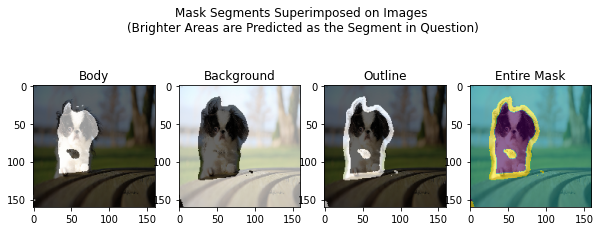

In [45]:
def separate_mask_parts(mask):
    '''
    Separates masks into its background, border, and outline components
    Parameter: mask of shape (width, height, 1)
    Returns: Background, body, and outline images, each of shape (width, height, 1)
    '''
    mask = np.squeeze(mask)
    mask_shape = mask.shape
    background = np.zeros(mask_shape)
    body = np.zeros(mask_shape)
    outline = np.zeros(mask_shape)
    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            if mask[i][j] == 0:
                background[i][j] = 1
            elif mask[i][j] == 1:
                body[i][j] = 1
            elif mask[i][j] == 2:
                outline[i][j] = 1
    return np.expand_dims(background, axis=-1), np.expand_dims(body, axis=-1), np.expand_dims(outline, axis=-1)

background_pred, body_pred, outline_pred = separate_mask_parts(y_pred_class[2])
background_true, body_true, outline_true = separate_mask_parts(y_test[2])

fig, axes = plt.subplots(1, 4, figsize=(10,8))

plt.suptitle('Mask Segments Superimposed on Images \n(Brighter Areas are Predicted as the Segment in Question)')

# Masks Overlaid on Images
axes[0].imshow(x_test[2])
axes[0].imshow(background_pred, alpha=0.6, cmap = plt.cm.gray)
axes[0].set_title('Body')

axes[1].imshow(x_test[2])
axes[1].imshow(body_pred, alpha=0.6, cmap = plt.cm.gray)
axes[1].set_title('Background')

axes[2].imshow(x_test[2])
axes[2].imshow(outline_pred, alpha=0.6, cmap = plt.cm.gray)
axes[2].set_title('Outline')

axes[3].imshow(x_test[2])
axes[3].imshow(y_pred_class[2], alpha=0.6)
axes[3].set_title('Entire Mask')
fig.subplots_adjust(top=1.35)

plt.show()

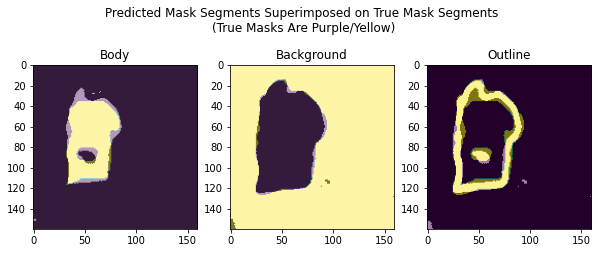

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(10,8))

plt.suptitle('Predicted Mask Segments Superimposed on True Mask Segments \n(True Masks Are Purple/Yellow)')

# Predicted Masks Overlaid on True Masks
axes[0].imshow(background_true, alpha=0.8)
axes[0].imshow(background_pred, alpha=0.5, cmap = plt.cm.gray)
axes[0].set_title('Body')

axes[1].imshow(body_true, alpha=0.8)
axes[1].imshow(body_pred, alpha=0.5, cmap = plt.cm.gray)
axes[1].set_title('Background')

axes[2].imshow(outline_true, alpha=1)
axes[2].imshow(outline_pred, alpha=0.5, cmap = plt.cm.gray)
axes[2].set_title('Outline')

fig.subplots_adjust(top=1.35)
plt.show()

As is evident from the scores, the IoU for the background and body is substantially higher than for the outline. Further, the scores for the background and the body are about the same. This makes sense. The border is relatively narrow compared to the other class, so IoU will be more sensetive to errors in prediction. This can be seen the images above. Further, because in addition to its narrowness, it encompasses the body and is surrounded by background, more point on an image may be considered borderline cases than for the body or background. The relative similarity between the body and the background is also unsurprising. Given the narrowness of the border, if the model does even a middling job of predicting the border, as here, it should do well predicting the body and background other than borderline cases.

# Conclusion
A U-Net-style model was trained to perform semantic segmentation on images of pets. The model achieved an acceptable performance in identify pet backgrounds and bodies, as measured using intersection over union but struggled to identify outlines.